In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import numpy as np
import scipy.cluster.vq
import scipy.interpolate
import sklearn.cluster
import sklearn.mixture
import warnings


def unit_vector(vector):
    return vector / np.linalg.norm(vector)


def normalize_vectors(vectors):
    norms = np.apply_along_axis(np.linalg.norm, 1, vectors)
    return vectors / norms.reshape(-1, 1)


def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


def get_colormap(colormap, res):
    get_color = lambda i: list(colormap(i))
    return np.array(list(map(get_color, np.linspace(0, 1, res))))


def draw_lines_with_colors(ax, points, colors, fmt=None, **kwargs):
    points = points[:,:2]
    first = True
    for x, y, r, g, b, a in np.hstack((points, colors)):
        if not first:
            args = [fmt] if fmt else []
            ax.plot([prev_x, x], [prev_y, y], color=[r, g, b], *args, **kwargs)
        prev_x = x
        prev_y = y
        first = False
        

def init_axes(ax):
    ax.set_aspect(1)
    ax.axis([0, 20, 0, 10])


def subplots(rows=1, cols=1, *args, **kwargs):
    kwargs.setdefault('figsize', (15, 4))
    fig, axs = plt.subplots(rows, cols, *args, **kwargs)
    return fig, axs


def start_plot(fig=None, col=1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    init_axes(ax)
    return ax


def quantize_color(n):
    return cm.tab20c(n/20)


def draw_marker(ax, X, Y, t, fmt='ko', ms=10):
    i = int(t * (X.size-1))
    ax.plot(X[i], Y[i], fmt, ms=ms, alpha=0.8)

t_range = (0., 1., 0.025)

In [2]:
# Example shape 1:

def get_shape1():
    def f(x):
        return ((x/2-5)**3 -(x/2-3)**2 + 50) / 10.

    X = np.linspace(0, 20, 100)
    Y = np.vectorize(f)(X)
    return X, Y

X, Y = get_shape1()

In [ ]:
# Example shape 2:

_xk = np.array([3, 5, 10, 15, 18, 14, 10, 6, 3])
_yk = np.array([3, 7, 6, 9, 5, 2, 3, 2, 3])
_tk = np.linspace(0, 1, _xk.size)

def get_shape2():
    with warnings.catch_warnings():
        # `spline` is deprecated for some dumb reason.
        warnings.simplefilter("ignore")
        T = np.linspace(0, 1, 100)
        X = scipy.interpolate.spline(_tk, _xk, T)
        Y = scipy.interpolate.spline(_tk, _yk, T)
    return X, Y, T

X, Y, T = get_shape2()

@interact(t=t_range)
def plot(t, **kwargs):
    fig, ax = subplots()
    fig.suptitle('Shape 2 - parametric spline')
    init_axes(ax)
    ax.plot(X, Y, lw=4, alpha=0.5)
    ax.plot(_xk, _yk, 'gx', ms=10)
    draw_marker(ax, X, Y, t)

#kwargs = {'x{}'.format(i): }

In [ ]:
# T: t-values
# D: plane d-values (ax+by+cz+d=0)
# Z: z-coords
# P: points
# G: gradients
# N: normals

T = np.linspace(0, 1, len(X)).reshape(len(X))
Z = np.zeros(len(X))
P = np.stack([X, Y, Z], 1)
G = normalize_vectors(np.gradient(P, axis=0))
N = normalize_vectors(np.cross(np.tile([0, 0, 1], (len(X), 1)), G))
C = np.average(P, axis=0)
D = np.array(-np.sum(N*(P-C), axis=1))

_grad_lines = np.stack([P-3*G, P+3*G], 1)
_normal_lines = np.stack([P, P+N], 1)

@interact(t=t_range, count=(4, 16))
def plot(t, count=8):
    fig, ax = subplots()
    init_axes(ax)
    fig.suptitle('Normals')

    ax.plot(X, Y, lw=4, alpha=0.5)

    step_size = int(X.size/count)
    items = list(zip(P, _grad_lines, _normal_lines))[::step_size]
    for point, grad_line, normal_line in items:
        ax.plot(point[0], point[1], 'ro', alpha=0.5)
        ax.plot(grad_line[:,0], grad_line[:,1], 'r--', alpha=0.5)
        ax.plot(normal_line[:,0], normal_line[:,1], 'g-', alpha=0.5)
        
    ax.plot(C[0], C[1], 'b+', alpha=0.5)
    draw_marker(ax, X, Y, t)

In [5]:
#_colors = get_colormap(cm.tab20c, X.size)

_angles = np.arctan2(N[:,0], N[:,1])
_offsets = D - np.min(D)
_offsets /= np.max(_offsets)

phase = np.stack([
    np.cos(_angles),
    np.sin(_angles),
], 1) * (_offsets + 2)[:,np.newaxis]


def partition(items, labels):
    split_indexes = np.where(np.diff(labels))[0] + 1
    split_items = np.split(items, split_indexes)
    split_labels = [x[0] for x in np.split(labels, split_indexes)]
    return zip(split_labels, split_items)


def draw_partitioned_shape(ax, labels):
    for label, points in partition(P, labels):
        ax.plot(points[:,0], points[:,1], color=quantize_color(label), lw=2)
        ax.plot(points[0,0], points[0,1], 'o', color=quantize_color(label), ms=8)


def draw_phase(ax, labels, t):
    colors = np.array(list(map(quantize_color, list(labels))))
    ax.set_title('Phase')
    for label, points in partition(phase, labels):
        ax.plot(points[:,0], points[:,1], color=quantize_color(label), alpha=0.3, lw=8)
        ax.plot(points[:,0], points[:,1], color=quantize_color(label), alpha=0.6, lw=2)
    ax.scatter(phase[:,0], phase[:,1], color=colors, s=75, alpha=0.3)
    draw_marker(ax, phase[:,0], phase[:,1], t, ms=15)


def get_labels(count):
    return np.array([int(i / X.size * count) for i in range(X.size)])

    
@interact(t=t_range, count=(1, 30))
def plot(t, count):
    labels = get_labels(count)
    
    fig, (ax0, ax1) = subplots(1, 2)
    fig.suptitle('Uniform partitioning')
    
    init_axes(ax0)
    ax0.set_title('Shape')
    draw_partitioned_shape(ax0, labels)
    draw_marker(ax0, X, Y, t)
    ax0.plot(C[0], C[1], 'b+', alpha=0.5)

    draw_phase(ax1, labels, t)

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.025), IntSlider(value=15, descri…

In [6]:
def get_labels(num_clusters):
    #_items = T[:,np.newaxis]
    _items = P
    #_items = np.hstack([T[:,np.newaxis]*5, N, _offsets[:,np.newaxis]])

    learner = sklearn.cluster.KMeans(n_clusters=num_clusters).fit(_items)
    labels = learner.predict(_items)

    #labels = sklearn.cluster.AgglomerativeClustering(n_clusters=N_CLUSTERS).fit_predict(_items)
    return labels


@interact(t=t_range, num_clusters=(1, 30))
def plot(t, num_clusters=11):
    labels = get_labels(num_clusters)
    fig, (ax0, ax1) = subplots(1, 2)
    fig.suptitle('K-means partitioning')

    init_axes(ax0)
    
    draw_partitioned_shape(ax0, labels)

    draw_marker(ax0, X, Y, t)
    ax0.plot(C[0], C[1], 'b+', alpha=0.5)

    draw_phase(ax1, labels, t)

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.025), IntSlider(value=11, descri…

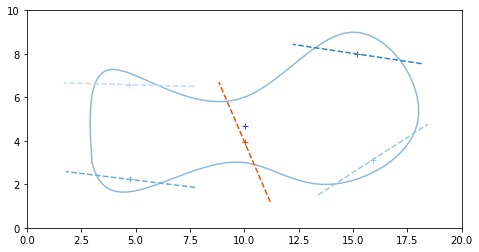

In [7]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    
    Source: https://stackoverflow.com/questions/12299540/plane-fitting-to-4-or-more-xyz-points
    """
    points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trialing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    M = np.dot(x, x.T) # Could also use np.cov(x) here.
    return ctr, np.linalg.svd(M)[0][:,-1]
    
labels = get_labels(5)
planes = []
plane_centers = []
points_by_label = []
for label in set(labels):
    points = P[labels == label]
    p, n = planeFit(points[:,:2].T)
    p = np.append(p, 0)
    n = np.append(n, 0)
    d = -n.dot(p-C)
    plane = np.append(n, d)
    planes.append(plane)
    plane_centers.append(p)



fig, ax0 = subplots()
init_axes(ax0)
ax0.plot(P[:,0], P[:,1], alpha=0.5)
ax0.plot(C[0], C[1], 'b+', alpha=0.8)    

for label, plane, plane_center in zip(set(labels), planes, plane_centers):
    a, b, c, d = plane
    grad = np.array([-b / a, 1, 0])
    grad = grad / np.linalg.norm(grad)
    
    xyz = np.vstack([plane_center - 3*grad, plane_center + 3*grad])
    ax0.plot(plane_center[0], plane_center[1], '+', color=quantize_color(label))
    ax0.plot(xyz[:,0], xyz[:,1], '--', color=quantize_color(label))